# Still needing to do list:


* Someone to look over the code I have done so far and check for any mistakes! Particularly with the model fitting to obtain the zero-point magnitude and extinction coefficients.
* Errors for the zero-point magntidue and extinction coefficient (just used the code from obsastro last year so I didn't really put any thought into it. it needs to be done properly!)
* Plot a graph for the parameter uncertainties obtained from the model fit function? (see workshop 4, slide 17/18)
* Dust extinction??? Does these calcualtions affect our values and errors for the final calibrated magnitude of WASP or it is just extra information we state alongside it?
* -> Does this affect colour excess? Do we need to calcualte colour excess?
* Calculate colours for WASP (i've already done B-V)
* Calculate errors for colours for WASP (not even started or thought about yet)
* Calcualte the curve of growth for each standard star (the aperture might change for each standard star??)

# Import packages

Different packages used:

* matplotlib.pyplot
* matplotlib.colors
* numpy
* astropy.io
* astropy.stats
* glob??
* os??
* photometryExercise
* photutils.aperture
* photutils.detection
* photometryExercise
* scipy.optimize

Write a description of each of these packages and the functions used?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
from photometryExercise import standardPlot
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from photutils.detection import DAOStarFinder
from photometryExercise import standardPlot
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

In [2]:
from bokeh.io import show, output_notebook
# set local host for bokeh (change the number to the one in the url at the top of the page)
localhost = 'localhost:8888'

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.


# Defining functions

In [5]:
def show_fits(data, title=""):
    """
    stolen from the obs astro code but like the backend code they wrote which we didn't see
    """
    plt.figure(figsize=(8, 8))
    
    # Use ZScale for astronomical images
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
    
    plt.imshow(data, origin='lower', cmap='gray', norm=norm)
    plt.colorbar(label='Counts')
    plt.title(title)
    print(f"{title}: min={np.min(data):.1f}, max={np.max(data):.1f}, median={np.median(data):.1f}")
    print(f"Display range (ZScale): {vmin:.1f} to {vmax:.1f}")
    plt.show()
    
trim = 50  # idk what this should be lol

In [6]:
def flux_to_mag(C):
    """
    Calculates the apparent magnitude from the total flux.

    Parameters
    ---
    C : float or array_like
        The total flux or counts. This value must be positive

    Returns
    ---
    float or array_like
        The calcualted apparents magnitude. Returns np.nan if the input C is non-positive
    """

    # check if the counts are negative
    if C <= 0:
        print("Counts are non-positive")
        return np.nan
        
    return - 2.5 * np.log10(C)

In [7]:
def error_in_mag(C, s):
    """
    Estimates the error in the apparent mangitude measurement based on Poisson statistics.

    Parameters
    ----------
    C : float or array_like
        Net counts (or flux) from the object (C_object). This must be positive.
    s : float or array_like
        Total counts (or flux) measured from the sky background within the 
        same aperture area (C_sky). Must be non-negative.

    Returns
    -------
    float or array_like
        The estimated 1-sigma uncertainty (error) in the apparent magnitude (Δm).
        Returns np.nan if the net object counts (C) is non-positive.
    """

    # calculate the total counts within the aperture t
    t = C + s

    # calculate the final area of the objects counts by summing in quadrature of the errors
    del_C = np.sqrt(t + s)

    # calculate and return the magnitude error
    return - 2.5 / np.log(10) * (del_C / C)

In [8]:
def instrumental_magnitudes(f, xcor, ycor, rAperture=5):
    """
    Performs aperture photometry on an astronomical image (FITS file) to obtain 
    the net instrumental magnitude and its associated error for a single source.

    The sky background is estimated using a surrounding annulus and subtracted 
    from the total flux within the object aperture.

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image data.
    xcor : float
        The x-coordinate of the source centroid.
    ycor : float
        The y-coordinate of the source centroid.
    rAperture : int, optional
        The radius of the circular aperture in pixels. Default is 5.

    Returns
    -------
    tuple
        A tuple containing:
        1. instrumental_magnitude (float): The calculated instrumental magnitude.
        2. instrumental_magnitude_error (float): The estimated 1-sigma error on 
           the instrumental magnitude.
    """

    standard = fits.open(f)[0].data

    # create the ciruclar aperture and sky annulus
    rSkyInner = 1.5 * rAperture
    rSkyOuter = 2 * rAperture

    apertureStandard = CircularAperture((xcor, ycor), r=rAperture)
    annulusSky = CircularAnnulus((xcor, ycor), r_in=rSkyInner, r_out=rSkyOuter)

    # make an estimation of the sky values in the defined annulus
    # aperture_photometry returns an astropy.table with the center of the aperture and 
    # the total flux on the aperture ('aperture_sum')
    sky = aperture_photometry(standard, annulusSky)
    #print(sky)

    # to recover the mean sky value, weight the total flux by the area of the annulus
    area = np.pi * (rSkyOuter ** 2 - rSkyInner **2)
    skyFlux = sky['aperture_sum'].value[0]
    meanSkyValue = skyFlux / area
    #print(f'The sky flux is {skyFlux}')
    #print(f'The mean sky value is {meanSkyValue}')

    # remove the sky value
    standard = aperture_photometry(standard - meanSkyValue, apertureStandard)

    # extract value from astropy.table
    standardFlux = standard['aperture_sum'].value[0]
    #print(f'The total flux on aperture is {standardFlux}')

    # calculating instrumental magnitude and its errors and append to list
    instrumental_magnitude = flux_to_mag(standardFlux)
    instrumental_magnitude_error = error_in_mag(standardFlux, skyFlux)

    return instrumental_magnitude, instrumental_magnitude_error

In [9]:
def airmasses(f):
    """
    Calculates the airmass (X) of an observation using the plane-parallel 
    atmosphere approximation: X = 1 / cos(z), where z is the zenith angle.

    It extracts the 'ALTITUDE' of the observation from the FITS file header 
    and converts it to the zenith angle (z = 90 - Altitude).

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image. 
        The primary header (HDU 0) must contain a keyword 'ALTITUDE' 
        (in degrees).

    Returns
    -------
    float
        The calculated airmass of the observation. Returns np.nan if the 
        FITS file cannot be read or the ALTITUDE keyword is missing.
    """

    with fits.open(f) as hdul:
        header = hdul[0].header

    altitude = header['ALTITUDE']
    #print(f"the altitude is {altitude}")
    zenith_angle = 90.0 - altitude
    #print(f"the zenith angle is {zenith_angle}")

    # convert to radians
    zenith_angle_rad = np.deg2rad(zenith_angle)

    # calcualte airmass
    airmass = 1.0 / np.cos(zenith_angle_rad)
    #print(f"the airmass is {airmass}")

    return airmass

In [10]:
def coordinates(f, xcor, ycor, aperture_radius = 5, sigma = 3.0, fwhm = 3.0):
    """
    Finds the precise (x, y) coordinates of the star closest to the initial 
    guess (xcor, ycor) by using DAOStarFinder for accurate centroiding.

    This function is crucial for high-precision photometry as it corrects for 
    slight drifts or errors in telescope pointing.

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image data.
    xcor : float
        The initial estimated x-coordinate (guess) for the star's position.
    ycor : float
        The initial estimated y-coordinate (guess) for the star's position.
    aperture_radius : int, optional
        The radius to be used for a potential aperture (used for context, not
        used for calculation in this function, default is 5).
    sigma : float, optional
        The sigma clipping level used for background estimation (sigma_clipped_stats). 
        Default is 3.0.
    fwhm : float, optional
        The full width at half maximum of the stellar profile in pixels, used 
        by DAOStarFinder. Default is 3.0.

    Returns
    -------
    tuple (float, float)
        The refined (x, y) centroid coordinates of the star closest to the guess.
        Returns (np.nan, np.nan) if the file cannot be read or no stars are found.
    """

    # open data
    hdul = fits.open(f)
    image_data = hdul[0].data

    # Detect stars in this image
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
    sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
    distances = np.sqrt((sources['xcentroid'] - xcor)**2 + (sources['ycentroid'] - ycor)**2)
    idx = np.argmin(distances)
    star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    # Photometry at the detected position
    #aperture = CircularAperture(star_pos, r=aperture_radius)
    #aperstats = ApertureStats(image_data, aperture)
    hdul.close()

    return star_pos

In [11]:
def star_location_plot(f, xcor, ycor, xmin=700, xmax=1200, ymin=700, ymax=1200):
    """
    Plots the image data, zooms in on a specified region, and highlights all 
    detected stars, with the target star marked in red.

    This function is used for visually confirming the centroiding accuracy.

    Parameters
    ----------
    f : str
        The filepath of the FITS file containing the astronomical image data.
    xcor : float
        The initial estimated x-coordinate (guess) for the star's position.
    ycor : float
        The initial estimated y-coordinate (guess) for the star's position.
    xmin, xmax, ymin, ymax : int, optional
        The pixel boundaries for the zoomed-in plot view (default: 700 to 1200).
    """

    fwhm = 3.0
    sigma = 3.0

    # open data
    hdul = fits.open(f)
    image_data = hdul[0].data

    # Detect stars in this image
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
    sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
    distances = np.sqrt((sources['xcentroid'] - xcor)**2 + (sources['ycentroid'] - ycor)**2)
    idx = np.argmin(distances)
    star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    x2 = 98
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=6)
    plt.figure()
    plt.imshow(image_data, origin='lower', norm=LogNorm(vmin=np.median(image_data), vmax=np.percentile(image_data, x2)), interpolation='nearest')
    apertures.plot(color='blue', lw=1.0, alpha=0.5)

    target_aperture = CircularAperture(star_pos, r=6)
    target_aperture.plot(color='red', lw=1.0, alpha=0.5) # Use a slightly thicker line (lw=2.5) for visibility
    
    plt.xlim(700, 1200)  # x-axis pixel range
    plt.ylim(700, 1200)  # y-axis pixel range
    
    print(f, star_pos[0], star_pos[1])
    
    plt.show()

In [12]:
def mean_ins_mag_vs_airmass(filter):
    """
    Calculates the mean instrumental magnitude, combined error, and mean airmass 
    for all standard stars observed under a specific filter.

    The instrumental magnitude errors are combined in quadrature (root sum of squares).

    Parameters
    ----------
    filter : str
        The photometric filter band ('B', 'I', 'R', or 'V').

    Returns
    -------
    tuple of (list, list, list)
        (mean_ins_mag_list, mean_ins_mag_err_list, mean_airmass_list)
        Each list contains one value per standard star (4 values total).
    """

    # create empty lists to store data
    ins_mag = []
    ins_mag_err = []
    airmass = []   

    # Determine the index slice for the filter
    if filter == 'B':
        start_idx, end_idx = 0, 3
    elif filter == 'I':
        start_idx, end_idx = 3, 6
    elif filter == 'R':
        start_idx, end_idx = 6, 9
    elif filter == 'V':
        start_idx, end_idx = 9, 12
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")
        return [], []

    # iterate through all four standard stars
    for i in range(0,4):

        ins_m = stars_ins_mag[i]
        ins_m_err = stars_ins_mag_err[i]
        airm = stars_airmass[i]

        mean_ins_mag = np.mean(ins_m[start_idx:end_idx])
        mean_ins_mag_err = np.sqrt(ins_m_err[start_idx]**2 + ins_m_err[start_idx+1]**2 + ins_m_err[start_idx+2]**2) # add the errors in quadrature
        mean_airmass = np.mean(airm[start_idx:end_idx])

        ins_mag.append(mean_ins_mag)
        ins_mag_err.append(mean_ins_mag_err)
        airmass.append(mean_airmass)
            
    return ins_mag, ins_mag_err, airmass

In [13]:
# write a function to calculate the obtain all values of a certain filter
def filter_ins_mag_vs_airmass(filter):
    """
    Returns the instrumental magnitudes, combined error, and airmasses
    for all standard stars for a specific filter.

    Parameters
    ----------
    filter : str
        The photometric filter band ('B', 'I', 'R', or 'V').

    Returns
    -------
    tuple of (list, list, list)
        (ins_mag_list, ins_mag_err_list, airmass_list)
        Each list contains multiple (3) values per standard star (12 values total).
    """

    # create empty lists to store data
    ins_mags = []
    ins_mags_err = []
    airmasses = []   

    # Determine the index slice for the filter
    if filter == 'B':
        start_idx, end_idx = 0, 3
    elif filter == 'I':
        start_idx, end_idx = 3, 6
    elif filter == 'R':
        start_idx, end_idx = 6, 9
    elif filter == 'V':
        start_idx, end_idx = 9, 12
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")
        return [], []

    # iterate through all four standard stars
    for i in range(0,4):

        ins_m = stars_ins_mag[i]
        ins_m_err = stars_ins_mag_err[i]
        airm = stars_airmass[i]

        ins_mag = ins_m[start_idx:end_idx]
        ins_mag_err = ins_m_err[start_idx:end_idx]
        airmass = airm[start_idx:end_idx]

        ins_mags.extend(ins_mag)
        ins_mags_err.extend(ins_mag_err)
        airmasses.extend(airmass)

    return ins_mags, ins_mags_err, airmasses

In [14]:
# write a function to calculate the obtain all values of a certain filter for wasp
def wasp_filter_ins_mag_vs_airmass(filter):
    """
    Returns the instrumental magnitudes, combined error, and airmasses
    for all standard stars for a specific filter.

    Parameters
    ----------
    filter : str
        The photometric filter band ('B', 'I', 'R', or 'V').

    Returns
    -------
    tuple of (list, list, list)
        (ins_mag_list, ins_mag_err_list, airmass_list)
        Each list contains multiple (3) values per standard star (12 values total).
    """

    # create empty lists to store data
    ins_mags = []
    ins_mags_err = []
    airmasses = []   

    # Determine the index slice for the filter
    if filter == 'B':
        start_idx, end_idx = 0, 3
    elif filter == 'I':
        start_idx, end_idx = 3, 6
    elif filter == 'R':
        start_idx, end_idx = 6, 9
    elif filter == 'V':
        start_idx, end_idx = 9, 12
    else:
        # If the filter is not recognized, return empty lists
        print(f"Filter '{filter}' not recognized.")
        return [], []

    ins_mag = target_ins_mags[start_idx:end_idx]
    ins_mag_err = target_ins_mag_errs[start_idx:end_idx]
    airmass = target_airmasses[start_idx:end_idx]

    ins_mags.extend(ins_mag)
    ins_mags_err.extend(ins_mag_err)
    airmasses.extend(airmass)

    return ins_mags, ins_mags_err, airmasses

In [15]:
def model(x, a, b):
    """
    Linear model function for atmospheric extinction correction, typically
    used with scipy.optimize.curve_fit.

    This function represents the observed instrumental magnitude (m) as a
    linear function of air mass (X), based on the standard extinction equation:
    m = m_0 + k * X

    The modeled relationship is: y = b - a * x, where:
    - x corresponds to the air mass (X)
    - b corresponds to the zero-airmass, or "exo-atmospheric," magnitude (m_0)
    - -a corresponds to the first-order extinction coefficient (k)

    Parameters
    ----------
    x : array-like
        The independent variable, typically the **Air Mass (X)**, which is
        often approximated by sec(zenith_distance).
    a : float
        The first fitting parameter, representing the **negative of the
        extinction coefficient (-k)** in magnitudes per air mass.
    b : float
        The second fitting parameter, representing the **zero-airmass magnitude (m_0)**
        of the celestial object.

    Returns
    -------
    array-like
        The modeled dependent variable, representing the **instrumental magnitude (m)**
        at the given air mass(es) x.
    """
    return b - a * x

In [16]:
def perform_extinction_correction(magnitudes, airmasses, magnitude_errors, filter_name, print_text=True):
    """
    Performs a linear fit to observational data (magnitude vs. airmass)
    to determine the atmospheric extinction coefficient and the zero-point
    magnitude. It uses scipy.optimize.curve_fit, including
    magnitude uncertainties for weighted fitting, and generates a scatter plot
    of the data with the best-fit line.

    The fit uses the model: magnitude = m_0 - k * X, where X is the airmass.

    Parameters
    ----------
    magnitudes : array-like
        Observed instrumental magnitudes (y-data) of the celestial object
        at different times.
    airmasses : array-like
        The corresponding Air Mass (X) values (x-data) for each observation,
        typically sec(zenith_distance).
    magnitude_errors : array-like
        The observational uncertainty (standard error) associated with each
        instrumental magnitude measurement. These are used as 'sigma' in
        curve_fit for weighted fitting.
    filter_name : str
        The name of the photometric filter (e.g., 'V', 'R', 'B') to be
        used in the plot title and output printout.

    Returns
    -------
    tuple
        A tuple containing the four fitted parameters and their standard errors:
        (a_fit, a_error, b_fit, b_error), where:
        - a_fit: The negative of the extinction coefficient (-k).
        - a_error: The standard error of a_fit.
        - b_fit: The zero-airmass magnitude (m_0).
        - b_error: The standard error of b_fit.

    Notes
    -----
    The function prints the calculated Extinction Coefficient (k = -a_fit)
    and the Zero-Point Magnitude (m_0 = b_fit) with their respective errors.
    It relies on a separate function 'model' and the 'numpy', 'matplotlib.pyplot',
    and 'scipy.optimize.curve_fit' packages.
    """

    # make sure the errors are positive
    magnitude_errors = np.abs(magnitude_errors)
    
    # Fit the model to the data   curve_fit(model, x, y, errors)
    #params, covariance = curve_fit(model, airmasses, magnitudes, sigma = magnitude_errors)
    params, covariance = curve_fit(model, airmasses, magnitudes) # don't include the errors for now
    
    # Extract the fitted parameters
    a_fit, b_fit = params
    cov_matrix = covariance
    
    # Calculate the parameter errors (standard deviations)
    a_error = np.sqrt(cov_matrix[0, 0])  # Uncertainty of a (slope)
    b_error = np.sqrt(cov_matrix[1, 1])  # Uncertainty of b (intercept)

    # Create the fitted curve
    x_fit = np.linspace(min(airmasses), max(airmasses), 100)
    y_fit = model(x_fit, *params)
    
    # Plot the data and the fitted line
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(airmasses, magnitudes)
    ax.plot(x_fit, y_fit, label="Best fit function", color='red')

    # plot the error bars
    #ax.errorbar(airmasses, magnitudes, yerr=magnitude_errors, fmt='o', label="Data", capsize=1)

    if print_text==True:
        # Calculate k and its error (k = -a_fit)
        k_fit = a_fit

        # Format the text using LaTeX for nice rendering
        text_k = r'Extinction Coeff. ($k$): ' + f'${k_fit:.4f} \pm {a_error:.4f}$'
        text_m0 = r'Zero-Point Mag. ($m_0$): ' + f'${b_fit:.4f} \pm {b_error:.4f}$'

        # Add text to the plot (using normalized coordinates, top left corner)
        ax.text(0.1, 0.2, text_k, 
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8, ec="gray"))

        ax.text(0.1, 0.1, text_m0,
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8, ec="gray"))
    
    # Set labels and title
    ax.set_xlabel(r'Airmass ($\sec\theta$)')
    ax.set_ylabel('$m_{true}$ - $m_{obs}$')
    ax.set_title(f'Airmass $\sec(theta)$ versus ($m_{{true}}$ - $m_{{obs}}$) for {filter_name} Filter')
    ax.legend()
    
    # Show the plot
    plt.show()

    print("-" * 50)
    print(f"Filter: {filter_name}")
    print(f"Extinction Coefficient (k): {a_fit:.4f} ± {a_error:.4f}")
    print(f"Zero-Point Magnitude (m_{0}): {b_fit:.4f} ± {b_error:.4f}")
    print("-" * 50)

    # where a_fit = -k, a_error = k_error
    return a_fit, a_error, b_fit, b_error

# Set path directorys for data

In [17]:
# path settings
BASE_DIR = "data"

# standard stars + target fits files
STANDARD_DIR = os.path.join(BASE_DIR, "standards")

# individual standard stars + target
STAR1 = os.path.join(STANDARD_DIR, "star1")
STAR2 = os.path.join(STANDARD_DIR, "star2")
STAR3 = os.path.join(STANDARD_DIR, "star3")
STAR4 = os.path.join(STANDARD_DIR, "star4")
TARGET = os.path.join(STANDARD_DIR, "target")

# retrieving the data from the folders
star1_files = sorted(glob.glob(os.path.join(STAR1, "*.fits")))
star2_files = sorted(glob.glob(os.path.join(STAR2, "*.fits")))
star3_files = sorted(glob.glob(os.path.join(STAR3, "*.fits")))
star4_files = sorted(glob.glob(os.path.join(STAR4, "*.fits")))
target_files = sorted(glob.glob(os.path.join(TARGET, "*.fits")))

# Find coordinates for standards

Printed out the images for each star using the standardPlot function to zoom in and identify the star in the images,
manually obtaining the x- and y-coordinates.

This was intially done for the first image of each star.

Unhash the correct line in the codes to run it.

In [18]:
# find coordinates for star 1
with fits.open(star1_files[3]) as hdul:
    #print(star1_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [19]:
# find coordinates for star 2
with fits.open(star2_files[0]) as hdul:
    #print(star2_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [20]:
# find coordinates for star 3
with fits.open(star3_files[0]) as hdul:
    #print(star3_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [21]:
# find coordinates for star 4
with fits.open(star4_files[0]) as hdul:
    #print(star4_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

In [22]:
# find coordinates for wasp135b
with fits.open(target_files[0]) as hdul:
    print(target_files[0])
    image_data = hdul[0].data
    #show_fits(image_data)
    #standardPlot(image_data, notebook_url=localhost)

data/standards/target/PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_1.fits


# Check the identified star is correct

Using the manually created star_location_plot (which uses DOAStarFinder), input starting point x- and y-coordinates
(which were found and noted down using the code above)
and the function will "follow" the star as its position slightly changes in each image.

This is just to confirm that the identified star and the coordinates are correct.

Unhash the correct lines in the codes to run it. 
(it takes a while)

In [23]:
# unhash to print out the locations of star1 images

# for the B filter
#for f in star1_files[:3]:
 #   star_location_plot(f, 970.50, 982.54)

# for the other filters
#for f in star1_files[3:]:
 #   star_location_plot(f, 986, 912)

In [24]:
# print out the locations of star2 images

# for all filters
#for f in star2_files:
#    star_location_plot(f, 993.53, 979.93)

In [25]:
# print out the locations of star3 images

# for all filters
#for f in star3_files:
  #  star_location_plot(f, 995.10, 935.05)

In [26]:
# print out the locations of star4 images

# for all filters
#for f in star4_files:
#    star_location_plot(f, 1059.54, 937.49)

In [27]:
# print out the locations of wasp135b images

# for all filters
#for f in target_files:
#    star_location_plot(f, 972.15, 954.72)

# Obtain the instrumental magnitudes and its errors

Using a loop to iterate through all the files in the appropriate path for each standard star, saving the information in a list. Used the manually created functions: coordinates, instrumental_magnitudes, airmasses.

Unhash the correct lines in the codes to print out the values as they are obtained.

## Star 1

In [28]:
# write a loop to obtain the instrumental magnitude and its errors
# for star1

star1_ins_mag = []
star1_ins_mag_err = []
star1_airmass = []
star1_tidied_f1 = []

for f in star1_files[:3]:

    # found only using the first image: PIRATE_OSL_ROE_EXO1_star1_filter_B_2.fits
    xcor = 970.50
    ycor = 982.54

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star1/"
    tidied_f1 = f.replace(prefix_to_remove, "")
    star1_tidied_f1.append(tidied_f1)
    #print(tidied_f1, ins_mag, ins_mag_err, airmass)  # unhash to print values

    star1_ins_mag.append(ins_mag)
    star1_ins_mag_err.append(ins_mag_err)
    star1_airmass.append(airmass)

for f in star1_files[3:]:

    # found only using the first image: PIRATE_OSL_ROE_EXO1_star1_filter_R_2.fits
    xcor = 986.50
    ycor = 912.54

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star1/"
    tidied_f1 = f.replace(prefix_to_remove, "")
    star1_tidied_f1.append(tidied_f1)
    #print(tidied_f1, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star1_ins_mag.append(ins_mag)
    star1_ins_mag_err.append(ins_mag_err)
    star1_airmass.append(airmass)

## Star 2

In [29]:
# write a loop to obtain the instrumental magnitude and its errors
# for star2

star2_ins_mag = []
star2_ins_mag_err = []
star2_airmass = []
star2_tidied_f2 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star2_filter_R_1.fits
xcor = 993.53
ycor = 979.93

for f in star2_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star2"
    tidied_f2 = f.replace(prefix_to_remove, "")
    star2_tidied_f2.append(tidied_f2)
    #print(tidied_f2, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star2_ins_mag.append(ins_mag)
    star2_ins_mag_err.append(ins_mag_err)
    star2_airmass.append(airmass)

## Star 3

In [30]:
# write a loop to obtain the instrumental magnitude and its errors
# for star3

star3_ins_mag = []
star3_ins_mag_err = []
star3_airmass = []
star3_tidied_f3 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star3_filter_I_2.fits
xcor = 995.10
ycor = 935.05

for f in star3_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star3"
    tidied_f3 = f.replace(prefix_to_remove, "")
    star3_tidied_f3.append(tidied_f3)
    #print(tidied_f3, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star3_ins_mag.append(ins_mag)
    star3_ins_mag_err.append(ins_mag_err)
    star3_airmass.append(airmass)

## Star 4

In [31]:
# write a loop to obtain the instrumental magnitude and its errors
# for star4

star4_ins_mag = []
star4_ins_mag_err = []
star4_airmass = []
star4_tidied_f4 = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_star4_filter_B_1.fits
xcor = 1059.54
ycor = 937.49

for f in star4_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star4"
    tidied_f4 = f.replace(prefix_to_remove, "")
    star4_tidied_f4.append(tidied_f4)
    #print(tidied_f4, ins_mag, ins_mag_err, airmass)   # unhash to print values

    star4_ins_mag.append(ins_mag)
    star4_ins_mag_err.append(ins_mag_err)
    star4_airmass.append(airmass)

## WASP-135b

In [32]:
# write a loop to obtain the instrumental magnitude and its errors
# for wasp135b

target_ins_mag = []
target_ins_mag_err = []
target_airmass = []
target_tidied_ft = []

# found only using the first image: PIRATE_OSL_ROE_EXO1_WASP135_Filter_B_1.fits
xcor = 972.15
ycor = 954.72

for f in target_files:

    # find the coordinates of the star using initial coordinates
    x, y = coordinates(f, xcor, ycor)

    # calculate the instrumental magnitudes 
    ins_mag, ins_mag_err = instrumental_magnitudes(f, x, y)

    # calculate the airmass
    airmass = airmasses(f)

    # print out values 
    prefix_to_remove = "data/standards/star4"
    tidied_ft = f.replace(prefix_to_remove, "")
    target_tidied_ft.append(tidied_ft)
    #print(tidied_ft, ins_mag, ins_mag_err, airmass)   # unhash to print values

    target_ins_mag.append(ins_mag)
    target_ins_mag_err.append(ins_mag_err)
    target_airmass.append(airmass)

## Put the standard star lists into a master list

In [33]:
stars_ins_mag = [star1_ins_mag, star2_ins_mag, star3_ins_mag, star4_ins_mag]
stars_ins_mag_err = [star1_ins_mag_err, star2_ins_mag_err, star3_ins_mag_err, star4_ins_mag_err]
stars_airmass = [star1_airmass, star2_airmass, star3_airmass, star4_airmass]

In [34]:
target_ins_mags = target_ins_mag
target_ins_mag_errs = target_ins_mag_err
target_airmasses = target_airmass

# Define standard magnitudes for all standard stars in each filer

In [35]:
# standard catalogue magntiudes for the four standard stars in each filter

# for standard star 1 (SA111-1965)
stn_mag_1_B = 13.129 
stn_mag_1_V = 11.419
stn_mag_1_R = 10.468
stn_mag_1_I = 9.589

# for standard star 2 (SA110 - 506)
stn_mag_2_B = 11.880
stn_mag_2_V = 11.312
stn_mag_2_R = 10.977
stn_mag_2_I = 10.660

# for standard star 3 (SA113_156)
stn_mag_3_B = 11.750
stn_mag_3_V = 11.224
stn_mag_3_R = 10.921
stn_mag_3_I = 10.606

# for standard star 4 (G26_7)
stn_mag_4_B = 13.674
stn_mag_4_V = 12.005
stn_mag_4_R = 10.705
stn_mag_4_I = 9.019

## Put the standard magnitudes into a master list

In [36]:
# make a list of standard magnitudes for each filter
stn_mags_B = [stn_mag_1_B, stn_mag_1_B, stn_mag_1_B, 
              stn_mag_2_B, stn_mag_2_B, stn_mag_2_B, 
              stn_mag_3_B, stn_mag_3_B, stn_mag_3_B, 
              stn_mag_4_B, stn_mag_4_B, stn_mag_4_B]
stn_mags_V = [stn_mag_1_V, stn_mag_1_V, stn_mag_1_V, 
              stn_mag_2_V, stn_mag_2_V, stn_mag_2_V, 
              stn_mag_3_V, stn_mag_3_V, stn_mag_3_V, 
              stn_mag_4_V, stn_mag_4_V, stn_mag_4_V]
stn_mags_R = [stn_mag_1_R, stn_mag_1_R, stn_mag_1_R, 
              stn_mag_2_R, stn_mag_2_R, stn_mag_2_R, 
              stn_mag_3_R, stn_mag_3_R, stn_mag_3_R, 
              stn_mag_4_R, stn_mag_4_R, stn_mag_4_R]
stn_mags_I = [stn_mag_1_I, stn_mag_1_I, stn_mag_1_I, 
              stn_mag_2_I, stn_mag_2_I, stn_mag_2_I, 
              stn_mag_3_I, stn_mag_3_I, stn_mag_3_I, 
              stn_mag_4_I, stn_mag_4_I, stn_mag_4_I]

# Obtain zero-point magnitudes and extinction coefficients for each filter

All three images for all four stars were plotted for each filter.

## B Filter

In [37]:
# define systematic error and use that for the errors? 

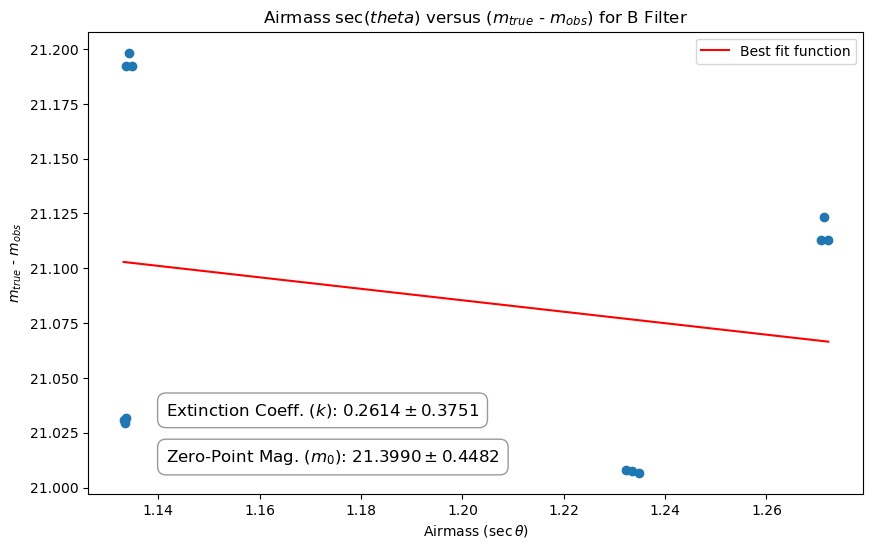

--------------------------------------------------
Filter: B
Extinction Coefficient (k): 0.2614 ± 0.3751
Zero-Point Magnitude (m_0): 21.3990 ± 0.4482
--------------------------------------------------


In [38]:
# plot for B filter

ins_mags_B, ins_mags_err_B, airmasses_B = filter_ins_mag_vs_airmass('B')
mags_B = np.array(stn_mags_B) - np.array(ins_mags_B)

k_B, k_B_err, m_zpt_B, m_zpt_B_err = perform_extinction_correction(mags_B, airmasses_B, ins_mags_err_B, 'B', 
                                                                   print_text = True)

#print(ins_mags_B)
#print(ins_mags_err_B)
#print(stn_mags_B)
#print(mags_B)
#print(airmasses_B)


## I Filter
This one is all funky and I don't know why!!

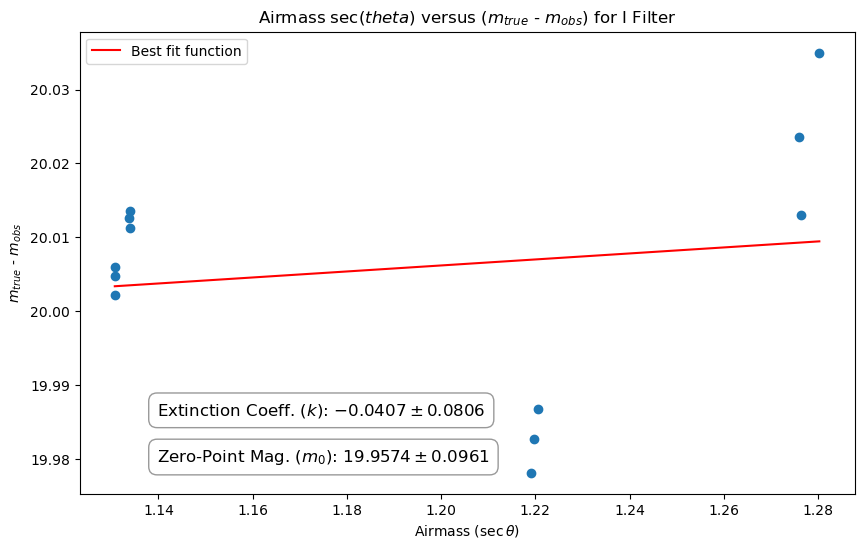

--------------------------------------------------
Filter: I
Extinction Coefficient (k): -0.0407 ± 0.0806
Zero-Point Magnitude (m_0): 19.9574 ± 0.0961
--------------------------------------------------


In [39]:
# plot for I filter
ins_mags_I, ins_mags_err_I, airmasses_I = filter_ins_mag_vs_airmass('I')
mags_I = np.array(stn_mags_I) - np.array(ins_mags_I)

k_I, k_I_err, m_zpt_I, m_zpt_I_err = perform_extinction_correction(mags_I, airmasses_I, ins_mags_err_I, 'I', 
                                                                   print_text = True)

## R Filter

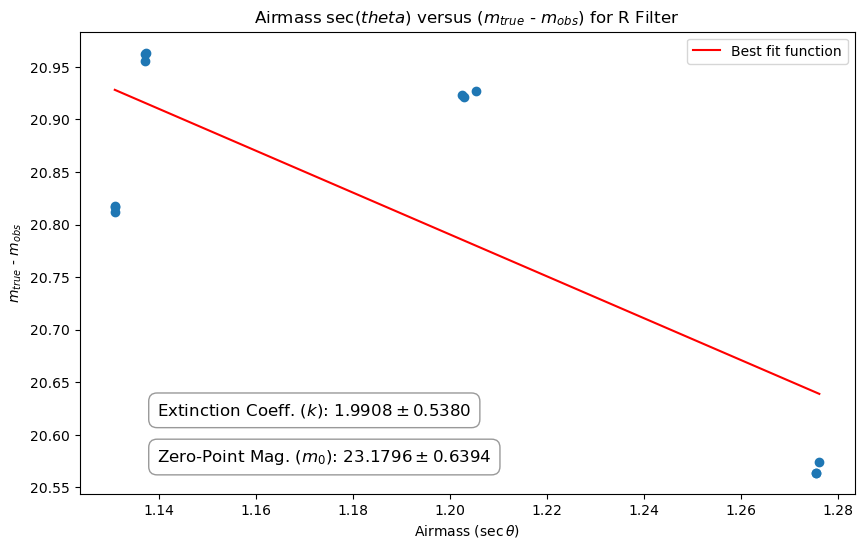

--------------------------------------------------
Filter: R
Extinction Coefficient (k): 1.9908 ± 0.5380
Zero-Point Magnitude (m_0): 23.1796 ± 0.6394
--------------------------------------------------


In [40]:
# plot for R filter
ins_mags_R, ins_mags_err_R, airmasses_R = filter_ins_mag_vs_airmass('R')
mags_R = np.array(stn_mags_R) - np.array(ins_mags_R)
#print(airmasses_R)

k_R, k_R_err, m_zpt_R, m_zpt_R_err = perform_extinction_correction(mags_R, airmasses_R, ins_mags_err_R, 'R', 
                                                                   print_text = True)

## V Filter

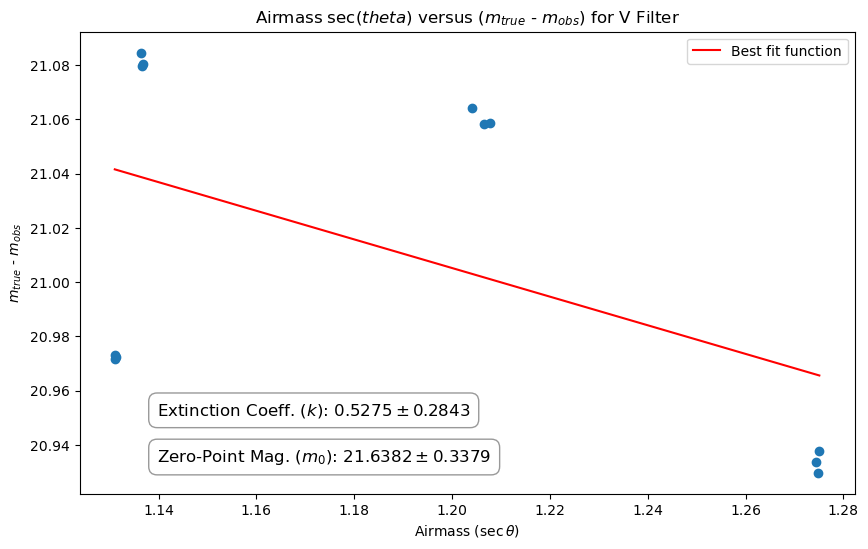

--------------------------------------------------
Filter: V
Extinction Coefficient (k): 0.5275 ± 0.2843
Zero-Point Magnitude (m_0): 21.6382 ± 0.3379
--------------------------------------------------


In [41]:
# plot for V filter
ins_mags_V, ins_mags_err_V, airmasses_V = filter_ins_mag_vs_airmass('V')
mags_V = np.array(stn_mags_V) - np.array(ins_mags_V)

k_V, k_V_err, m_zpt_V, m_zpt_V_err = perform_extinction_correction(mags_V, airmasses_V, ins_mags_err_V, 'V', 
                                                                   print_text = True)

# Calculate the final calibrated magnitude of WASP-135b

In [42]:
print(target_ins_mags)
print(target_ins_mag_errs)
print(target_airmasses)

[np.float64(-6.835151647711113), np.float64(-6.833375639189965), np.float64(-6.832944498709127), np.float64(-7.720384829338936), np.float64(-7.728510079686572), np.float64(-7.729794204659836), np.float64(-8.179393219714354), np.float64(-8.180397729617738), np.float64(-8.18769057938239), np.float64(-7.761405380155569), np.float64(-7.762997655500593), np.float64(-7.755535778802734)]
[np.float64(-0.12130989221007862), np.float64(-0.12197339094315), np.float64(-0.12249045828651908), np.float64(-0.04813488695550785), np.float64(-0.047932900884426005), np.float64(-0.04814467922462528), np.float64(-0.04085854589176174), np.float64(-0.04085163798935305), np.float64(-0.04066446620536408), np.float64(-0.05879483034204142), np.float64(-0.058945554830371914), np.float64(-0.05939619664681262)]
[np.float64(1.276107198519151), np.float64(1.283630861245674), np.float64(1.2918925471563008), np.float64(1.2080738702224947), np.float64(1.2277200810573516), np.float64(1.2328925603820595), np.float64(1.2388

In [43]:
# make empty lists to hold the values
target_ins_mag = []
target_ins_mag_err = []
target_airmass = []

## B Filter

In [85]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter B

ins_mag_target_B, ins_mags_err_target_B, airmasses_target_B = wasp_filter_ins_mag_vs_airmass('B')

m_target_B = ins_mag_target_B - (np.ones(len(airmasses_target_B)) * k_B * airmasses_target_B) + m_zpt_B
#print(m_target_B)
#print(airmasses_target_B)
#print(np.mean(airmasses_target_B))

mean_m_target_B = np.mean(m_target_B)
m_target_B_err = np.std(m_target_B)
print(f"{mean_m_target_B} ± {m_target_B_err}")

14.229624249911799 ± 0.0008630537143513355


## V Filter

In [86]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter V

ins_mag_target_V, ins_mags_err_target_V, airmasses_target_V = wasp_filter_ins_mag_vs_airmass('V')

m_target_V = ins_mag_target_V - (np.ones(len(airmasses_target_V)) * k_V * airmasses_target_V) + m_zpt_V
#print(m_target_V)
#print(airmasses_target_V)
#print(np.mean(airmasses_target_V))

mean_m_target_V = np.mean(m_target_V)
m_target_V_err = np.std(m_target_V)
print(f"{mean_m_target_V} ± {m_target_V_err}")

13.212526415694134 ± 0.0020872741199029084


## R Filter

In [87]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter R

ins_mag_target_R, ins_mags_err_target_R, airmasses_target_R = wasp_filter_ins_mag_vs_airmass('R')

m_target_R = ins_mag_target_R - (np.ones(len(airmasses_target_R)) * k_B * airmasses_target_R) + m_zpt_R
#print(m_target_R)
#print(airmasses_target_R)
#print(np.mean(airmasses_target_R))

mean_m_target_R = np.mean(m_target_R)
m_target_R_err = np.std(m_target_R)
print(f"{mean_m_target_R} ± {m_target_R_err}")

14.671957579837825 ± 0.004736934146777365


## I Filter

In [88]:
# now, calculate the final calibrated magnitude of wasp-135b!!!
# for filter I

ins_mag_target_I, ins_mags_err_target_I, airmasses_target_I = wasp_filter_ins_mag_vs_airmass('I')

m_target_I = ins_mag_target_I - (np.ones(len(airmasses_target_I)) * k_I * airmasses_target_I) + m_zpt_I
#print(m_target_I)
#print(airmasses_target_I)
#print(np.mean(airmasses_target_I))

mean_m_target_I = np.mean(m_target_I)
m_target_I_err = np.std(m_target_I)
print(f"{mean_m_target_I} ± {m_target_I_err}")

12.28088502414009 ± 0.0037326334953726747


# Calcualte the difference in colour magnitudes for WASP-135b

## B - V

In [92]:
B_V = mean_m_target_B - mean_m_target_V
print(B_V)

1.0170978342176653


## V - R

In [90]:
V_R = mean_m_target_V - mean_m_target_R
print(V_R)

-1.459431164143691


## R - I

In [91]:
R_I = mean_m_target_R - mean_m_target_I
print(R_I)

2.3910725556977344
